In [15]:
import os
from collections import defaultdict
os.environ['JAX_ENABLE_X64'] = 'True'
# Disable JAX compilation cache to avoid HDF5 issues
# os.environ['JAX_COMPILATION_CACHE_DIR'] = ''
# os.environ['JAX_DISABLE_JIT'] = '0'  # Keep JIT enabled but disable caching

import numpy as np
import numpy as jnp

from ptdalgorithms import Graph

def echo(*args):
    print('>>'+' {}'*len(args), *args)


# TODO: make this a method of Graph
def make_discrete(cont_graph, mutation_rate, skip_states=[], skip_slots=[]):
    """
    Takes a graph for a continuous distribution and turns
    it into a descrete one (inplace). Returns a matrix of
    rewards for computing marginal moments
    """

    graph = cont_graph.copy()

    # save current nr of states in graph
    vlength = graph.vertices_length()

    # number of fields in state vector (assumes all are the same length)
    state_vector_length = len(graph.vertex_at(1).state())

    # list state vector fields to reward at each auxiliary node
    # rewarded_state_vector_indexes = [[] for _ in range(state_vector_length)]
    rewarded_state_vector_indexes = defaultdict(list)

    # loop all but starting node
    for i in range(1, vlength):
        if i in skip_states:
            continue
        vertex = graph.vertex_at(i)
        if vertex.rate() > 0: # not absorbing
            for j in range(state_vector_length):
                if j in skip_slots:
                    continue
                val = vertex.state()[j]
                if val > 0: # only ones we may reward
                    # add auxilliary node
                    mutation_vertex = graph.create_vertex(np.repeat(0, state_vector_length))
                    mutation_vertex.add_edge(vertex, 1)
                    vertex.add_edge(mutation_vertex, mutation_rate*val)
                    # print(mutation_vertex.index(), rewarded_state_vector_indexes[j], j)
                    # rewarded_state_vector_indexes[mutation_vertex.index()] = rewarded_state_vector_indexes[j] + [j]
                    rewarded_state_vector_indexes[mutation_vertex.index()].append(j)

    # print(rewarded_state_vector_indexes)

    # normalize graph
    weights_were_multiplied_with = graph.normalize()

    # build reward matrix
    rewards = np.zeros((graph.vertices_length(), state_vector_length))
    for state in rewarded_state_vector_indexes:
        for i in rewarded_state_vector_indexes[state]:
            rewards[state, i] = 1

    rewards = np.transpose(rewards)
    return graph, rewards

# def build_graph(theta, cache_key=None): 
#     # cache_key is a dummy static argument that only serve to make jax
#     # cache on those values and not just on shape and dtype of theta
#     echo('"building" graph\n')

#     pop_size, mutation_rate = theta

#     def coalescent(state, nr_samples=None):
#         if not state.size:
#             ipv = [([nr_samples]+[0]*nr_samples, 1)]
#             return ipv
#         else:
#             transitions = []
#             for i in range(nr_samples):
#                 for j in range(i, nr_samples):            
#                     same = int(i == j)
#                     if same and state[i] < 2:
#                         continue
#                     if not same and (state[i] < 1 or state[j] < 1):
#                         continue 
#                     new = state.copy()
#                     new[i] -= 1
#                     new[j] -= 1
#                     new[i+j+1] += 1
#                     transitions.append((new, state[i]*(state[j]-same)/(1+same)))
#             return transitions

#     graph = Graph(callback=coalescent, nr_samples=3)

#     discrete_graph, rewards = make_discrete(graph, mutation_rate=mutation_rate)

#     return discrete_graph, rewards


def build_graph(theta, cache_key=None): 
    # cache_key is a dummy static argument that only serve to make jax
    # cache on those values and not just on shape and dtype of theta
    echo('"building" graph\n')

    pop_size, mutation_rate = theta

    def block_coalescent(state, nr_samples=None):
        if not state.size:
            return [([nr_samples], 1)]
        transitions = []
        if state[0] > 1:
            new = state.copy()
            new[0] -= 1
            transitions.append((new, state[0]*(state[0]-1)/2))
        print(transitions)
        return transitions

    graph = Graph(callback=block_coalescent, nr_samples=3)

    discrete_graph, rewards = make_discrete(graph, mutation_rate=mutation_rate)

    return discrete_graph, rewards



data = jnp.array([1, 2, 3], dtype=jnp.int64)
echo(f"Times: {data}")

_N, _u = 1000, 1/10 # just pop size times mut rate for testing (nonsensical of cause)
theta = jnp.array([_N, _u ], dtype=jnp.float64)  # Ensure double precision


###################################


graph, rewards = build_graph(theta)
#print(jnp.apply_along_axis(graph.expectation, 1, rewards))
graph.states()


>> {} Times: [1 2 3]
>> {} "building" graph

[(array([2], dtype=int32), np.float64(3.0))]
[(array([1], dtype=int32), np.float64(1.0))]
[]


array([[0],
       [3],
       [2],
       [1],
       [0],
       [0]], dtype=int32)

In [17]:

rev_trans_graph = graph.reward_transform(rewards[0])
rev_trans_graph.pmf_discrete(data)

# g, r = build_graph(theta, mutation_rate=0.1)
# echo('states:', g.states())
# echo('rewards:', r)

#echo('python log_pmf: ', python_jax_dph_pmf(theta, data))



array([0.19513315, 0.03878315, 0.00703304])

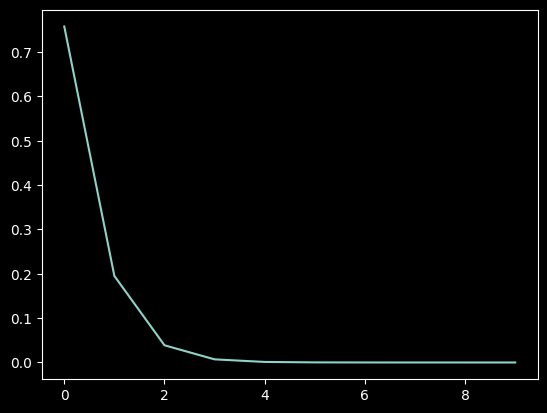

In [18]:
from matplotlib import pyplot as plt
x = np.arange(0, 10, 1)
plt.plot(rev_trans_graph.pmf_discrete(x))